In [2]:
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# --- Configuration ---

DATASET_PATH = "../TestDataSet"
DATASET_SPECIFIC_JSON_PATH = "../TestDataSet/labels_list.json"  # JSON listing class labels in order
ADVERSARIAL_DATASET_PATH = "../Adversarial_Test_Set_1"
MODEL_WEIGHTS = 'IMAGENET1K_V1'
BATCH_SIZE = 32                 # For evaluation and data loading
ATTACK_BATCH_SIZE = 1          # FGSM is applied per image
NUM_WORKERS = 0                # Set to >0 if using multiprocessing
EPSILON = 0.02                 # Given in the task
NUM_VISUALIZATIONS = 5         # Number of adversarial examples to visualize


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [5]:
model = torchvision.models.resnet34(weights=MODEL_WEIGHTS)
model.eval().to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Normalization constants for ImageNet
mean_norms = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
std_norms = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)

# Inverse normalization for visualization
inv_normalize = T.Normalize(
    mean=(-mean_norms / std_norms).squeeze().tolist(),
    std=(1.0 / std_norms).squeeze().tolist()
)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean_norms.squeeze().tolist(), std=std_norms.squeeze().tolist())
])

In [7]:
# Load class label indices from the JSON file
with open(DATASET_SPECIFIC_JSON_PATH, "r") as file:
    label_lines = json.load(file)

true_imagenet_indices = [int(entry.split(":")[0]) for entry in label_lines]


In [8]:
# Load dataset and remap class labels to ImageNet indices
image_folder = torchvision.datasets.ImageFolder(root=DATASET_PATH, transform=transform)

folder_to_imagenet_index = {
    class_name: true_imagenet_indices[idx]
    for idx, class_name in enumerate(image_folder.classes)
}

image_folder.samples = [
    (img_path, folder_to_imagenet_index[os.path.basename(os.path.dirname(img_path))])
    for img_path, _ in image_folder.samples
]


In [9]:
dataloader = DataLoader(image_folder, batch_size=1, shuffle=False)

In [ ]:
os.makedirs(ADVERSARIAL_DATASET_PATH, exist_ok=True)

In [30]:
# Fast Gradient Sign Method (FGSM) for adversarial attack
def fgsm_attack(image, label, epsilon):
    image.requires_grad = True

    outputs = model(image)
    loss = torch.nn.functional.cross_entropy(outputs, label)

    model.zero_grad()
    loss.backward()
    gradient_sign = image.grad.data.sign()
    epsilon_normalized = (epsilon / std_norms).view(1, 3, 1, 1) # Normalize epsilon change
    perturbed_image = image + epsilon_normalized * gradient_sign
    perturbed_image = torch.clamp(perturbed_image, min=0.0, max=1.0)

    return perturbed_image.detach()


In [31]:
# Generate and save adversarial examples using FGSM
adv_images = []
true_labels = []
prediction_changed = []

for idx, (input_img, target_label) in enumerate(tqdm(dataloader, desc="Generating FGSM")):
    input_img = input_img.to(device)
    target_label = target_label.to(device)

    # Get original prediction
    with torch.no_grad():
        original_prediction = model(input_img).argmax(dim=1).item()

    # Generate adversarial image
    adversarial_img = fgsm_attack(input_img.clone(), target_label, EPSILON)

    # Get prediction on adversarial image
    with torch.no_grad():
        adversarial_prediction = model(adversarial_img).argmax(dim=1).item()

    # Record data
    adv_images.append(adversarial_img.squeeze().cpu())
    true_labels.append(target_label.item())
    prediction_changed.append(original_prediction != adversarial_prediction)

    # Save adversarial image to disk
    filename = f"{idx:04d}.png"
    unnormalized = inv_normalize(adversarial_img.squeeze().cpu()).clamp(0, 1)
    save_path = os.path.join(ADVERSARIAL_DATASET_PATH, filename)
    torchvision.utils.save_image(unnormalized, save_path)


Generating FGSM: 100%|██████████| 500/500 [00:50<00:00,  9.88it/s]



Showing original vs adversarial images (where prediction changed):


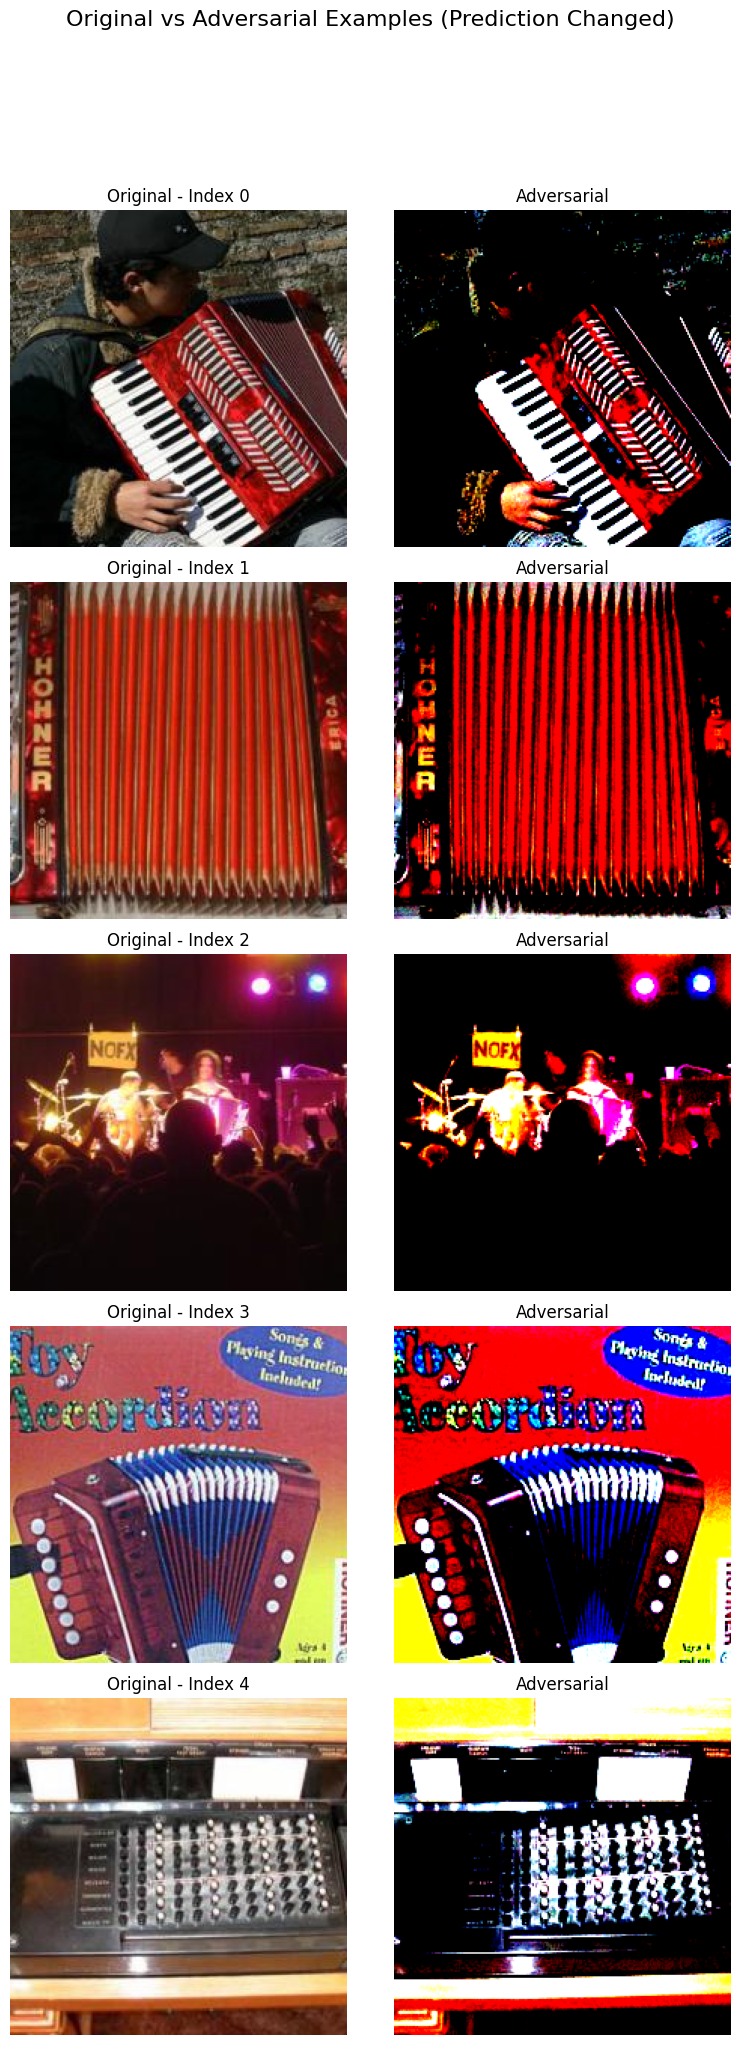

In [32]:

print("\nShowing original vs adversarial images (where prediction changed):")

# Find indices where predictions changed
changed_indices = [i for i, changed in enumerate(prediction_changed) if changed]
num_to_show = min(NUM_VISUALIZATIONS, len(changed_indices))

# Create subplot grid (rows = number of images, 2 columns for original & adversarial)
fig, axes = plt.subplots(num_to_show, 2, figsize=(8, 4 * num_to_show))

# Ensure axes is always 2D (even if only 1 row)
if num_to_show == 1:
    axes = [axes]

for i, idx in enumerate(changed_indices[:num_to_show]):
  
    original_img_tensor, _ = image_folder[idx] 
    original_img = inv_normalize(original_img_tensor).clamp(0, 1).numpy().transpose(1, 2, 0)

    adversarial_img = adv_images[idx].numpy().transpose(1, 2, 0)

    # Original image (left)
    axes[i][0].imshow(original_img)
    axes[i][0].set_title(f"Original - Index {idx}")
    axes[i][0].axis("off")

    # Adversarial image (right)
    axes[i][1].imshow(adversarial_img)
    axes[i][1].set_title("Adversarial")
    axes[i][1].axis("off")

# Add a clean top-level title
fig.suptitle("Original vs Adversarial Examples (Prediction Changed)", fontsize=16, y=1.02)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [33]:
# Dataset wrapper for adversarial examples
class AdversarialDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.image_list = images
        self.label_list = labels

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        return self.image_list[index], self.label_list[index]

# Create DataLoader for evaluating adversarial examples
adv_dataset = AdversarialDataset(adv_images, true_labels)
adv_loader = DataLoader(adv_dataset, batch_size=BATCH_SIZE)


In [34]:
def evaluate(model, dataloader):
    top1_hits = 0
    top5_hits = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            _, top1_preds = outputs.topk(1, dim=1)
            _, top5_preds = outputs.topk(5, dim=1)

            top1_hits += (top1_preds.squeeze() == targets).sum().item()
            top5_hits += sum(targets[i] in top5_preds[i] for i in range(targets.size(0)))
            total_samples += targets.size(0)

    top1_accuracy = 100 * top1_hits / total_samples
    top5_accuracy = 100 * top5_hits / total_samples

    return top1_accuracy, top5_accuracy


In [35]:
# Evaluate model on adversarial examples and report results
top1_accuracy_adv, top5_accuracy_adv = evaluate(model, adv_loader)

print("\n--- Adversarial Evaluation Results ---")
print(f"Top-1 Accuracy: {top1_accuracy_adv:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy_adv:.2f}%")



--- Adversarial Evaluation Results ---
Top-1 Accuracy: 13.60%
Top-5 Accuracy: 34.80%
